In [ ]:
import pandas as pd
import numpy as np

def generate_sequence():
    # Generate base values and random noise to simulate features
    base_values = np.random.rand(5)
    noise = np.random.normal(0, 0.1, (5, 5))  # Slight randomness
    sequence = np.array([base_values + i * 0.05 + noise[i] for i in range(5)])  # Gradual increase
    return sequence

def find_peak_feature(sequence):
    peak_values = []

    for i in range(5):
        feature_sequence = sequence[:, i]
        peak_index = np.argmax(feature_sequence)  # Index of the peak
        peak_value = feature_sequence[peak_index]

        # Check for increment-decrement pattern around the peak
        if peak_index > 0 and peak_index < len(feature_sequence) - 1:
            if feature_sequence[peak_index - 1] < peak_value > feature_sequence[peak_index + 1]:
                peak_values.append((i, peak_value))  # (feature index, peak value)
            else:
                peak_values.append((i, -1))  # No valid peak pattern if no increment-decrement
        else:
            peak_values.append((i, -1))  # No valid peak pattern if peak is at the start or end

    # Find the feature with the highest peak value that has a valid increment-decrement pattern
    peak_values = [p for p in peak_values if p[1] != -1]  # Filter out invalid peaks
    if peak_values:
        label = max(peak_values, key=lambda x: x[1])[0]  # Select feature with highest valid peak
    else:
        label = np.random.randint(0, 5)  # Random label if no valid peak is found
    return label

def generate_data(num_samples=100):
    data = []
    for _ in range(num_samples):
        sequence = generate_sequence()
        label = find_peak_feature(sequence)
        for row in sequence:
            data.append(list(row) + [label])
    return pd.DataFrame(data, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'predict'])

# Generate 100 samples
df = generate_data(num_samples=1000)

# Save to CSV
df.to_csv("generated_data.csv", index=False)
print("CSV file generated: 'generated_data.csv'")


CSV file generated: 'generated_data.csv'


final

In [ ]:
#1. custom dataset
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class CSVTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, sequence_length=5):
        self.data = pd.read_csv(csv_file)
        self.sequence_length = sequence_length
        self.num_sequences = len(self.data) // self.sequence_length
        self.features = self.data[['f1', 'f2', 'f3', 'f4', 'f5']].values
        self.labels = self.data['predict'].values[::self.sequence_length]

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        start_idx = idx * self.sequence_length
        end_idx = start_idx + self.sequence_length
        features = torch.tensor(self.features[start_idx:end_idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, label


In [ ]:
#2. model definition
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_classes=5, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # Get output from the last time step
        logits = self.fc(out)
        return logits


In [ ]:
#3. training and testing
import torch.optim as optim

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        accuracy = correct_preds / total_preds * 100
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Testing function
def test_model(model, test_loader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
    accuracy = correct_preds / total_preds * 100
    print(f"Test Accuracy: {accuracy:.2f}%")


In [ ]:
#4. putting togther
# Main script
csv_file = '/content/generated_data.csv'  # Replace with your CSV path
batch_size = 16
num_epochs = 58
learning_rate = 0.001

# Initialize dataset and dataloader
dataset = CSVTimeSeriesDataset(csv_file)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, optimizer
model = LSTMClassifier(input_size=5, hidden_size=64, num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Test the model
test_model(model, test_loader)


Epoch [1/58], Loss: 1.6004, Accuracy: 24.38%
Epoch [2/58], Loss: 1.5660, Accuracy: 30.88%
Epoch [3/58], Loss: 1.4742, Accuracy: 38.25%
Epoch [4/58], Loss: 1.4076, Accuracy: 40.50%
Epoch [5/58], Loss: 1.3813, Accuracy: 43.25%
Epoch [6/58], Loss: 1.3804, Accuracy: 41.38%
Epoch [7/58], Loss: 1.3675, Accuracy: 43.00%
Epoch [8/58], Loss: 1.3667, Accuracy: 43.38%
Epoch [9/58], Loss: 1.3618, Accuracy: 43.00%
Epoch [10/58], Loss: 1.3564, Accuracy: 42.62%
Epoch [11/58], Loss: 1.3535, Accuracy: 44.00%
Epoch [12/58], Loss: 1.3458, Accuracy: 44.12%
Epoch [13/58], Loss: 1.3519, Accuracy: 44.25%
Epoch [14/58], Loss: 1.3515, Accuracy: 43.75%
Epoch [15/58], Loss: 1.3422, Accuracy: 43.88%
Epoch [16/58], Loss: 1.3429, Accuracy: 43.88%
Epoch [17/58], Loss: 1.3472, Accuracy: 44.00%
Epoch [18/58], Loss: 1.3357, Accuracy: 45.75%
Epoch [19/58], Loss: 1.3399, Accuracy: 45.12%
Epoch [20/58], Loss: 1.3396, Accuracy: 44.88%
Epoch [21/58], Loss: 1.3353, Accuracy: 44.00%
Epoch [22/58], Loss: 1.3327, Accuracy: 44.7

In [ ]:
#5. live forcasting
def live_forecast(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        output = model(sequence_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_label = torch.argmax(probabilities, dim=1).item()
        print(f"Predicted Label: {predicted_label}")
        return predicted_label, probabilities.squeeze().tolist()


In [ ]:
#6. interface
import numpy as np

# Example CLI for user input
def get_user_sequence():
    print("Enter 5 time steps with 5 values each (separated by spaces):")
    sequence = []
    for i in range(5):
        step = input(f"Time step {i + 1}: ").strip().split()
        step = [float(val) for val in step]
        sequence.append(step)
    return np.array(sequence)

sequence = get_user_sequence()
label, probabilities = live_forecast(model, sequence)
print(f"Predicted Label: {label}")
print(f"Probabilities: {probabilities}")


Enter 5 time steps with 5 values each (separated by spaces):
Time step 1: 1 2 3 4 5
Time step 2: 2 3 4 5 6
Time step 3: 3 4 10 6 7
Time step 4: 4 5 6 7 8
Time step 5: 1 2 3 4 5
Predicted Label: 0
Predicted Label: 0
Probabilities: [0.45390787720680237, 0.11140066385269165, 0.028780167922377586, 0.01180808711796999, 0.39410313963890076]


In [ ]:
sequence = [
    [100, 200, 300, 400, 500],
    [200, 300, 400, 500, 500],
    [200, 400, 0, 600, 500],
    [200, 500, 600, 700, 500],
    [100, 200, 300, 400, 500],
]

label, probabilities = live_forecast(model, sequence)
print(f"Predicted Label: {label}")
print(f"Probabilities: {probabilities}")

Predicted Label: 3
Predicted Label: 3
Probabilities: [0.1915590763092041, 0.26792994141578674, 0.12600243091583252, 0.3294737935066223, 0.0850348174571991]


In [ ]:
sequence = [
    [100, 200, 300, 400, 500],
    [200, 300, 400, 500, 500],
    [200, 400, 800, 600, 500],
    [200, 500, 600, 300, 500],
    [100, 200, 300, 400, 500],
]

label, probabilities = live_forecast(model, sequence)
print(f"Predicted Label: {label}")
print(f"Probabilities: {probabilities}")

Predicted Label: 1
Predicted Label: 1
Probabilities: [0.22022008895874023, 0.27449172735214233, 0.2248391956090927, 0.23055845499038696, 0.04989054054021835]


In [ ]:
sequence = [
    [100, 200, 300, 400, 300],
    [200, 300, 400, 500, 500],
    [200, 400, 800, 600, 900],
    [200, 500, 600, 300, 500],
    [100, 200, 300, 400, 400],
]

label, probabilities = live_forecast(model, sequence)
print(f"Predicted Label: {label}")
print(f"Probabilities: {probabilities}")

Predicted Label: 0
Predicted Label: 0
Probabilities: [0.33269089460372925, 0.24550007283687592, 0.15758103132247925, 0.16317160427570343, 0.10105638951063156]


In [ ]:
torch.save(model.state_dict(),"/content/model.pth")

In [ ]:
# Model class must be defined somewhere
#model = torch.load(PATH, weights_only=False)
#model.eval()

Epoch [1/1], Training Loss: 1.5959
Test Loss: 1.5600
Epoch [1/1], Training Loss: 1.4676
Test Loss: 1.4449
Epoch [1/1], Training Loss: 1.4002
Test Loss: 1.4478
Epoch [1/1], Training Loss: 1.3914
Test Loss: 1.4423
Epoch [1/1], Training Loss: 1.3860
Test Loss: 1.4227
Epoch [1/1], Training Loss: 1.3825
Test Loss: 1.4188
Epoch [1/1], Training Loss: 1.3776
Test Loss: 1.4144
Epoch [1/1], Training Loss: 1.3755
Test Loss: 1.4240
Epoch [1/1], Training Loss: 1.3740
Test Loss: 1.4192
Epoch [1/1], Training Loss: 1.3649
Test Loss: 1.4250
Epoch [1/1], Training Loss: 1.3696
Test Loss: 1.4254
Epoch [1/1], Training Loss: 1.3662
Test Loss: 1.4338
Epoch [1/1], Training Loss: 1.3656
Test Loss: 1.4105
Epoch [1/1], Training Loss: 1.3655
Test Loss: 1.4133
Epoch [1/1], Training Loss: 1.3599
Test Loss: 1.4281
Epoch [1/1], Training Loss: 1.3582
Test Loss: 1.4197
Epoch [1/1], Training Loss: 1.3537
Test Loss: 1.4318
Epoch [1/1], Training Loss: 1.3562
Test Loss: 1.4114
Epoch [1/1], Training Loss: 1.3525
Test Loss: 

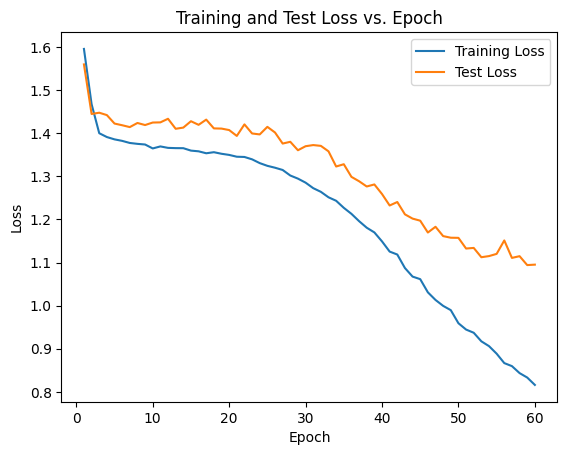

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming CSVTimeSeriesDataset, LSTMClassifier, train_model, and test_model are already defined

# Main script
csv_file = '/content/generated_data.csv'  # Replace with your CSV path
batch_size = 16
num_epochs = 60
learning_rate = 0.001

# Initialize dataset and dataloader
dataset = CSVTimeSeriesDataset(csv_file)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, optimizer
model = LSTMClassifier(input_size=5, hidden_size=64, num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss for each epoch
train_losses = []
test_losses = []

# Modified training function to record training loss
def train_model_with_loss_tracking(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Average loss for this epoch
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}")

# Modified testing function to record test loss
def test_model_with_loss_tracking(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    # Average test loss for this epoch
    avg_loss = total_loss / len(test_loader)
    test_losses.append(avg_loss)
    print(f"Test Loss: {avg_loss:.4f}")

# Train and record losses
for epoch in range(num_epochs):
    train_model_with_loss_tracking(model, train_loader, criterion, optimizer, num_epochs=1)
    test_model_with_loss_tracking(model, test_loader, criterion)

# Plotting the losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs. Epoch')
plt.legend()
plt.show()


Epoch [1/59]
Training Loss: 1.5836, Training Accuracy: 26.00%
Test Loss: 1.5502, Test Accuracy: 34.50%
Epoch [2/59]
Training Loss: 1.4632, Training Accuracy: 39.12%
Test Loss: 1.4164, Test Accuracy: 42.25%
Epoch [3/59]
Training Loss: 1.3973, Training Accuracy: 42.81%
Test Loss: 1.4093, Test Accuracy: 42.25%
Epoch [4/59]
Training Loss: 1.3845, Training Accuracy: 43.06%
Test Loss: 1.4078, Test Accuracy: 41.50%
Epoch [5/59]
Training Loss: 1.3819, Training Accuracy: 44.31%
Test Loss: 1.4104, Test Accuracy: 39.25%
Epoch [6/59]
Training Loss: 1.3755, Training Accuracy: 44.50%
Test Loss: 1.4025, Test Accuracy: 41.25%
Epoch [7/59]
Training Loss: 1.3699, Training Accuracy: 43.75%
Test Loss: 1.3878, Test Accuracy: 42.00%
Epoch [8/59]
Training Loss: 1.3690, Training Accuracy: 44.12%
Test Loss: 1.4379, Test Accuracy: 39.50%
Epoch [9/59]
Training Loss: 1.3685, Training Accuracy: 43.25%
Test Loss: 1.3869, Test Accuracy: 41.75%
Epoch [10/59]
Training Loss: 1.3641, Training Accuracy: 43.44%
Test Loss:

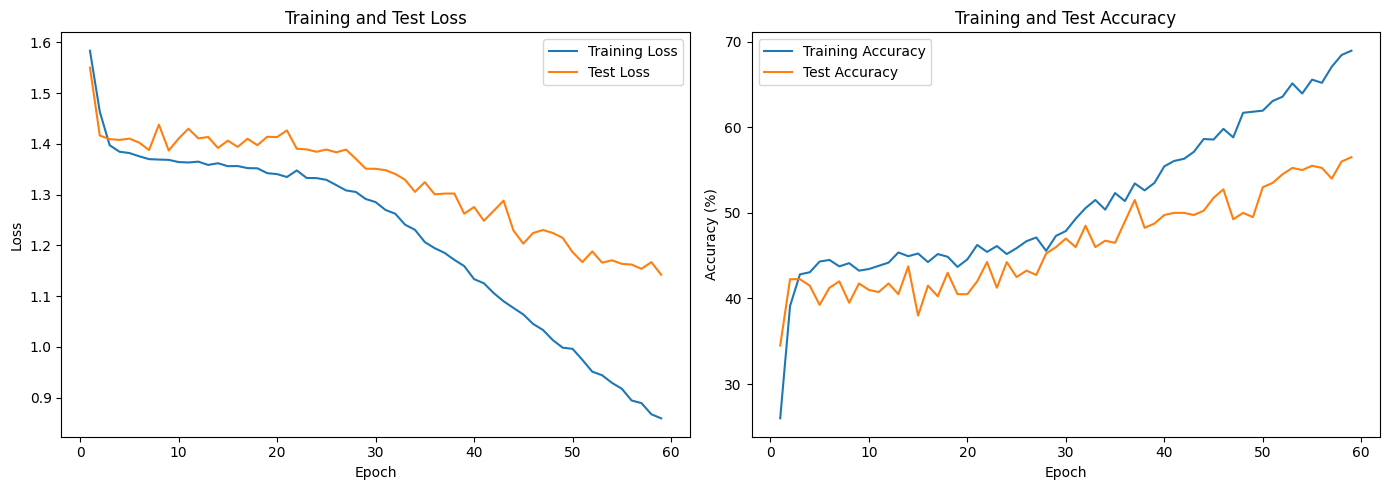

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming CSVTimeSeriesDataset, LSTMClassifier, train_model, and test_model are already defined

# Main script
csv_file = '/content/generated_data.csv'  # Replace with your CSV path
batch_size = 16
num_epochs = 59
learning_rate = 0.001

# Initialize dataset and dataloader
dataset = CSVTimeSeriesDataset(csv_file)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, optimizer
model = LSTMClassifier(input_size=5, hidden_size=64, num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss and accuracy for each epoch
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Modified training function to record training loss and accuracy
def train_model_with_tracking(model, train_loader, criterion, optimizer):
    model.train()
    correct = 0
    total = 0
    total_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update total loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%")

# Modified testing function to record test loss and accuracy
def test_model_with_tracking(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Update accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    test_losses.append(avg_loss)
    test_accuracies.append(accuracy)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Train and test the model for each epoch, recording losses and accuracies
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    train_model_with_tracking(model, train_loader, criterion, optimizer)
    test_model_with_tracking(model, test_loader, criterion)

# Plotting losses and accuracies
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch [1/59]
Epoch [2/59]
Epoch [3/59]
Epoch [4/59]
Epoch [5/59]
Epoch [6/59]
Epoch [7/59]
Epoch [8/59]
Epoch [9/59]
Epoch [10/59]
Epoch [11/59]
Epoch [12/59]
Epoch [13/59]
Epoch [14/59]
Epoch [15/59]
Epoch [16/59]
Epoch [17/59]
Epoch [18/59]
Epoch [19/59]
Epoch [20/59]
Epoch [21/59]
Epoch [22/59]
Epoch [23/59]
Epoch [24/59]
Epoch [25/59]
Epoch [26/59]
Epoch [27/59]
Epoch [28/59]
Epoch [29/59]
Epoch [30/59]
Epoch [31/59]
Epoch [32/59]
Epoch [33/59]
Epoch [34/59]
Epoch [35/59]
Epoch [36/59]
Epoch [37/59]
Epoch [38/59]
Epoch [39/59]
Epoch [40/59]
Epoch [41/59]
Epoch [42/59]
Epoch [43/59]
Epoch [44/59]
Epoch [45/59]
Epoch [46/59]
Epoch [47/59]
Epoch [48/59]
Epoch [49/59]
Epoch [50/59]
Epoch [51/59]
Epoch [52/59]
Epoch [53/59]
Epoch [54/59]
Epoch [55/59]
Epoch [56/59]
Epoch [57/59]
Epoch [58/59]
Epoch [59/59]


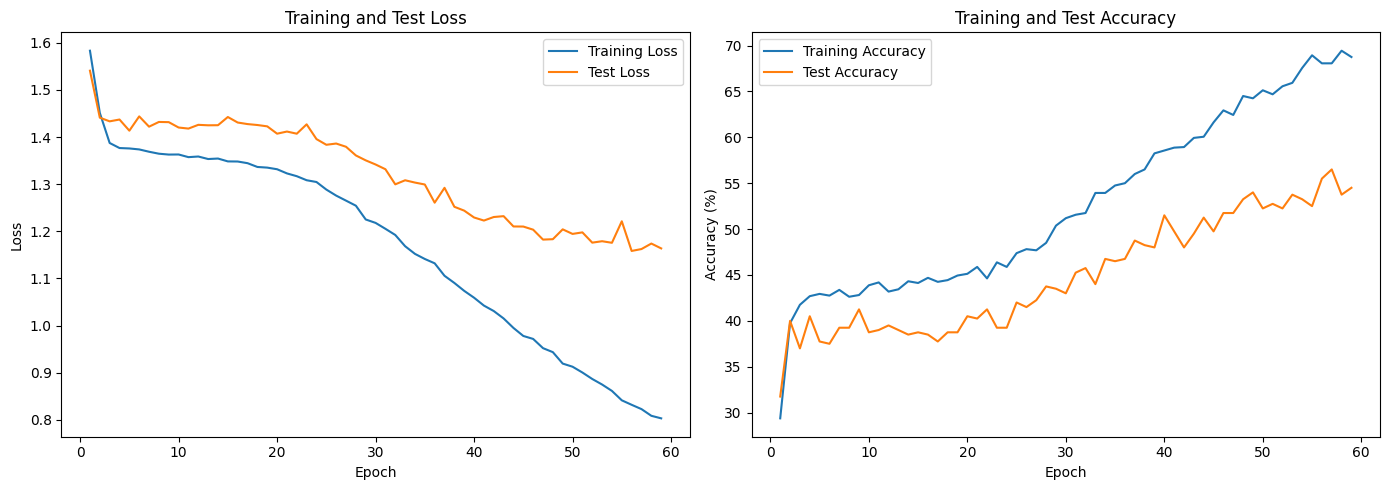

Iteration 1/100, LR: 0.000000, Loss: 0.6665
Iteration 2/100, LR: 0.000000, Loss: 1.3193
Iteration 3/100, LR: 0.000000, Loss: 1.1265
Iteration 4/100, LR: 0.000000, Loss: 0.6037
Iteration 5/100, LR: 0.000000, Loss: 0.8853
Iteration 6/100, LR: 0.000000, Loss: 0.6861
Iteration 7/100, LR: 0.000000, Loss: 0.7019
Iteration 8/100, LR: 0.000000, Loss: 0.6880
Iteration 9/100, LR: 0.000000, Loss: 0.5085
Iteration 10/100, LR: 0.000001, Loss: 0.9671
Iteration 11/100, LR: 0.000001, Loss: 1.0098
Iteration 12/100, LR: 0.000001, Loss: 0.6946
Iteration 13/100, LR: 0.000001, Loss: 0.9108
Iteration 14/100, LR: 0.000001, Loss: 0.6997
Iteration 15/100, LR: 0.000001, Loss: 0.7459
Iteration 16/100, LR: 0.000001, Loss: 0.9122
Iteration 17/100, LR: 0.000002, Loss: 1.0602
Iteration 18/100, LR: 0.000002, Loss: 0.7755
Iteration 19/100, LR: 0.000002, Loss: 0.5850
Iteration 20/100, LR: 0.000003, Loss: 0.8207
Iteration 21/100, LR: 0.000003, Loss: 0.7792
Iteration 22/100, LR: 0.000003, Loss: 0.3956
Iteration 23/100, L

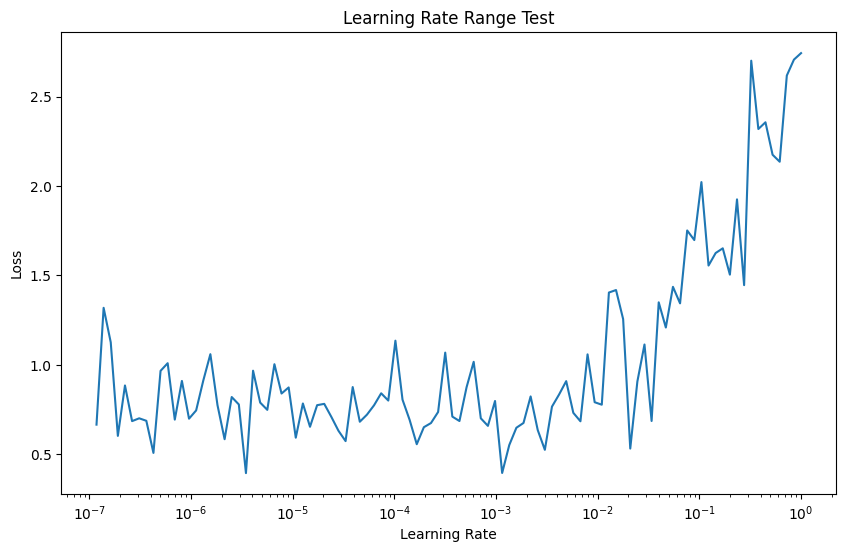

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

# Assuming CSVTimeSeriesDataset, LSTMClassifier, train_model, and test_model are already defined

# Main script parameters
csv_file = '/content/generated_data.csv'  # Replace with your CSV path
batch_size = 16
num_epochs = 59
initial_learning_rate = 0.001

# Initialize dataset and dataloader
dataset = CSVTimeSeriesDataset(csv_file)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, optimizer
model = LSTMClassifier(input_size=5, hidden_size=64, num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Lists to store loss and accuracy for each epoch
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training and testing functions to track loss and accuracy
def train_model_with_tracking(model, train_loader, criterion, optimizer):
    model.train()
    correct = 0
    total = 0
    total_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update total loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

def test_model_with_tracking(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Update accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    test_losses.append(avg_loss)
    test_accuracies.append(accuracy)

# Training loop with tracking
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    train_model_with_tracking(model, train_loader, criterion, optimizer)
    test_model_with_tracking(model, test_loader, criterion)

# Plotting training and test loss/accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Learning Rate Range Test
def lr_range_test(model, train_loader, criterion, min_lr=1e-7, max_lr=1, num_iter=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=min_lr)
    lr_lambda = lambda x: (max_lr / min_lr) ** (x / num_iter)
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    lrs, losses = [], []

    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        if i >= num_iter: break
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        # Record current learning rate and loss
        current_lr = scheduler.get_last_lr()[0]
        lrs.append(current_lr)
        losses.append(loss.item())
        print(f"Iteration {i+1}/{num_iter}, LR: {current_lr:.6f}, Loss: {loss.item():.4f}")

    return lrs, losses

# Run learning rate range test
lrs, losses = lr_range_test(model, train_loader, criterion, min_lr=1e-7, max_lr=1, num_iter=100)

# Plot Loss vs Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Range Test")
plt.show()
